# Feature selection

## 1. Introduction and Dataset Research

### 1.1 Introduction

Variable selection is essential in modern data analysis and data science. Identifying influential and informative features not only simplifies models by reducing the number of variables but also provides valuable insights into the data. Techniques such as Principal Component Analysis are commonly used for dimensionality reduction, often eliminating variables during the preprocessing stage. Alternatively, incorporating the selection procedure directly into the model fitting process via regularization constraints can offer significant advantages.

This project explores various variables selection methods; specifically, we focus on correlations, mutual information, SHAP (SHapley Additive exPlanations), Lasso, Elastic Net, and XGBoost to interpret and validate the importance of selected features. By applying these methods to a dataset of housing sale prices featuring 80 variables including 43 categorical features, we aim to discuss the underlying principles for these methods and their performance on the real-world data. The analysis provides insights into the advantages and limitations of each method in addressing different types of data and relationships, such as non-linearity, collinearity, and interactions.

### 1.2 Goals
* conduct a comparative analysis for each model's selected features
* understand how the proposed methods work on a real-world dataset with various types of features, find the best method

### 1.3 Dataset

Anna Montoya and DataCanary. House Prices - Advanced Regression Techniques. https://kaggle.com/competitions/house-prices-advanced-regression-techniques, 2016. Kaggle.

"Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home."

## 2. Exploratory data analysis and preprocessing 

In [335]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import json
import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from tqdm.notebook import tqdm
from scipy.stats import skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import json
import re
import pprint
import json
from collections import defaultdict

In [222]:
# the dataset
df = pd.read_csv(
    'train.csv',
    na_values=[],
    keep_default_na=False  # Prevent "None" and other default markers from being treated as NaN
)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL          65     8450   Pave    NA      Reg   
1   2          20       RL          80     9600   Pave    NA      Reg   
2   3          60       RL          68    11250   Pave    NA      IR1   
3   4          70       RL          60     9550   Pave    NA      IR1   
4   5          60       RL          84    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [223]:
df = df.set_index('Id') # setting the index

In [224]:
df.dtypes.value_counts() # object and int64 types

object    46
int64     34
Name: count, dtype: int64

In [225]:
df.describe()

MSSubClass        LotArea  OverallQual  OverallCond    YearBuilt  \
count  1460.000000    1460.000000  1460.000000  1460.000000  1460.000000   
mean     56.897260   10516.828082     6.099315     5.575342  1971.267808   
std      42.300571    9981.264932     1.382997     1.112799    30.202904   
min      20.000000    1300.000000     1.000000     1.000000  1872.000000   
25%      20.000000    7553.500000     5.000000     5.000000  1954.000000   
50%      50.000000    9478.500000     6.000000     5.000000  1973.000000   
75%      70.000000   11601.500000     7.000000     6.000000  2000.000000   
max     190.000000  215245.000000    10.000000     9.000000  2010.000000   

       YearRemodAdd   BsmtFinSF1   BsmtFinSF2    BsmtUnfSF  TotalBsmtSF  ...  \
count   1460.000000  1460.000000  1460.000000  1460.000000  1460.000000  ...   
mean    1984.865753   443.639726    46.549315   567.240411  1057.429452  ...   
std       20.645407   456.098091   161.319273   441.866955   438.705324  ...   
min     1950.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%     1967.000000     0.000000     0.000000   223.000000   795.750000  ...   
50%     1994.000000   383.500000     0.000000   477.500000   991.500000  ...   
75%     2004.000000   712.250000     0.000000   808.000000  1298.250000  ...   
max     2010.000000  5644.000000  1474.000000  2336.000000  6110.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 34 columns]

In [226]:
df[["BsmtFinType1", "BsmtFinType2"]]  # dropping this redundant feature
cols_to_drop = ["BsmtFinType2"]
df = df.drop(columns=cols_to_drop)

The dataset has N/A and null values that are mixed up with the categories of some variables. Here, we'll properly handle "N/A" and "None".

In [227]:
na_to_no_item_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
none_to_no_item_cols = ["MasVnrType"]

In [228]:
# checking if there any None in the na_to_no_item_cols columns
s = 0 
for col in na_to_no_item_cols:
    print(df[col].value_counts())
    flag = "None" in df[col].value_counts().keys()
    print(flag)
    s += int(flag)
print(s) 

Alley
NA      1369
Grvl      50
Pave      41
Name: count, dtype: int64
False
BsmtQual
TA    649
Gd    618
Ex    121
NA     37
Fa     35
Name: count, dtype: int64
False
BsmtCond
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: count, dtype: int64
False
BsmtExposure
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: count, dtype: int64
False
BsmtFinType1
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: count, dtype: int64
False
FireplaceQu
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: count, dtype: int64
False
GarageType
Attchd     870
Detchd     387
BuiltIn     88
NA          81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64
False
GarageFinish
Unf    605
RFn    422
Fin    352
NA      81
Name: count, dtype: int64
False
GarageQual
TA    1311
NA      81
Fa      48
Gd      14
Ex       3
Po       3
Name: count, dtype: int64
False
GarageCond
TA    1326
NA      81
Fa      35
Gd       9
Po       7
Ex 

In [229]:
df[none_to_no_item_cols].value_counts()

MasVnrType
None          864
BrkFace       445
Stone         128
BrkCmn         15
NA              8
Name: count, dtype: int64

In [230]:
# replacing the categorical values found with "No_item"
df[na_to_no_item_cols] = df[na_to_no_item_cols].replace("NA", "No_item")
df[none_to_no_item_cols] = df[none_to_no_item_cols].replace("None", "No_item")

In [231]:
# counting N/A
d_na = {}
for col in df.columns:
    # print(col)
    if "NA" in df[col].value_counts():
        temp = df[col].value_counts().reset_index()
        if temp.keys:
            # print(temp.loc[temp[col] == "NA"]["count"].item())
            d_na[col] = temp.loc[temp[col] == "NA"]["count"].item()
d_na

{'LotFrontage': 259,
 'MasVnrType': 8,
 'MasVnrArea': 8,
 'Electrical': 1,
 'GarageYrBlt': 81}

In [232]:
for col in d_na.keys(): # iterating over cols with N/As
    df[col] = df[col].replace("NA", np.nan)

In [233]:
df['LotFrontage'] = pd.to_numeric(df['LotFrontage'])
df['MasVnrArea'] = pd.to_numeric(df['MasVnrArea'])
df['GarageYrBlt'] = pd.to_numeric(df['GarageYrBlt'])

In [234]:
df.isna().sum().sum()

np.int64(357)

In [235]:
# df.to_csv('train_prepared_for_cv.csv') # saving for later use

In [236]:
df_nulls = df.isna().sum()[df.isna().sum() > 0]

Plotting the remaining nulls 

In [239]:
# importing the dictionaries with description of columns
with open("columns_dict.json", "r") as json_file:
    columns_dict = json.load(json_file)
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

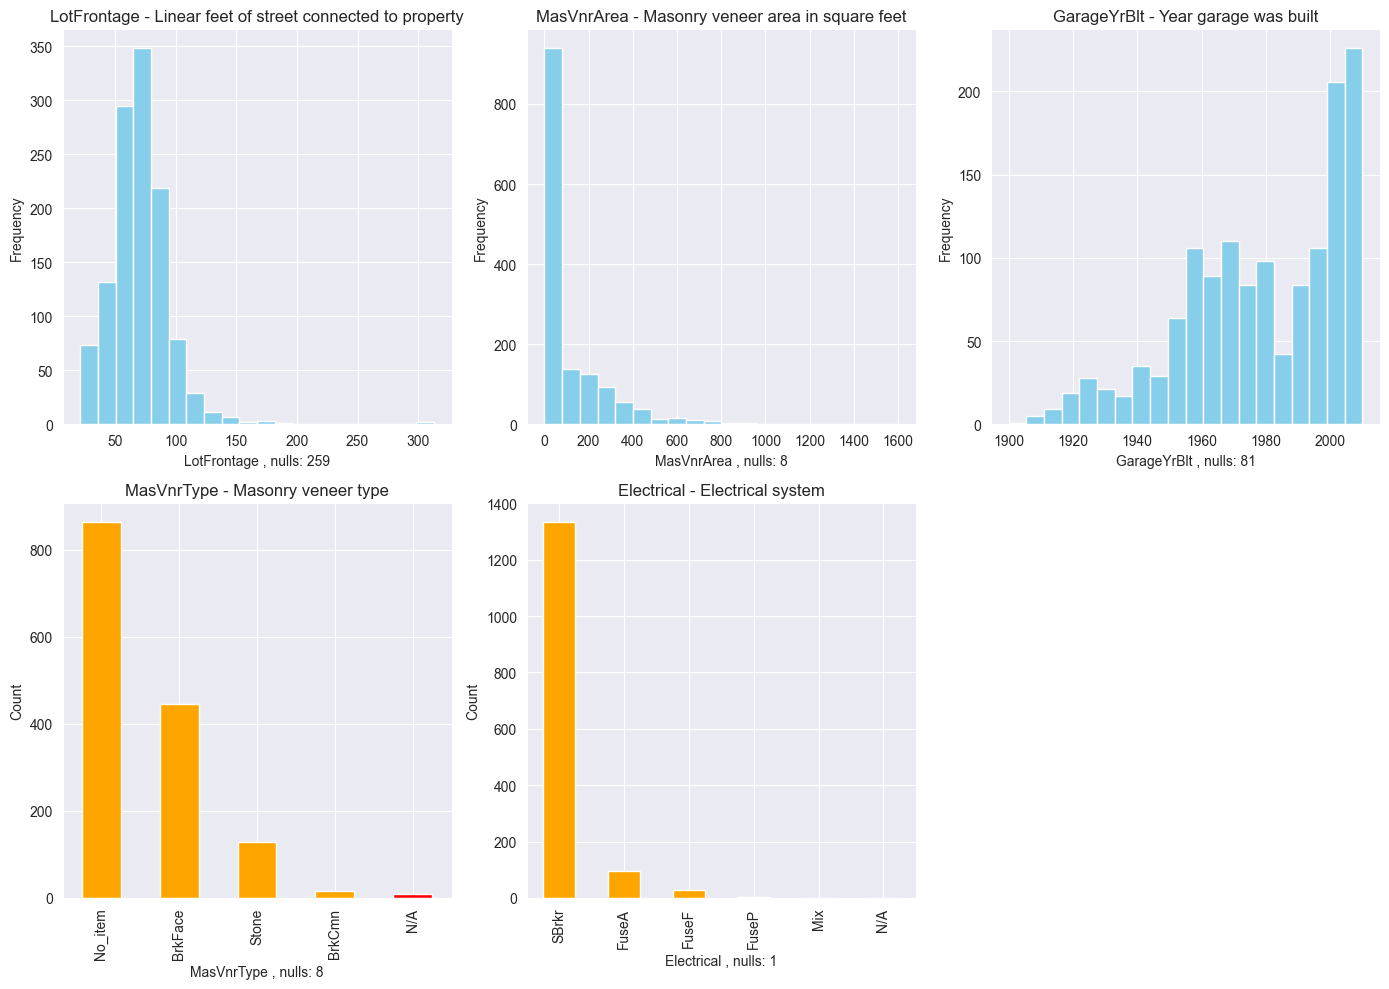

In [240]:
columns_with_nans = df.columns[df.isna().any()]
numeric_cols_with_nans = [col for col in columns_with_nans if df[col].dtype in ['int64', 'float64']]
categorical_cols_with_nans = [col for col in columns_with_nans if col not in numeric_cols_with_nans]

all_columns = numeric_cols_with_nans + categorical_cols_with_nans
num_cols = len(all_columns)

rows = ceil(num_cols / 3)
fig, axes = plt.subplots(rows, 3, figsize=(14, rows * 3 + 4))
axes = axes.flatten()

for i, col in enumerate(all_columns):
    ax = axes[i]
    title = col + " - " + columns_dict.get(col, "")
    x_label = col + " , nulls: " + str(df_nulls[col])
    if col in numeric_cols_with_nans:
        df[col].plot(kind='hist', bins=20, ax=ax, title=title, color='skyblue')
        ax.set_xlabel(x_label)
    elif col in categorical_cols_with_nans:
        value_counts = df[col].fillna("N/A").value_counts()
        colors = ["orange" if index != "N/A" else "red" for index in value_counts.index]
        value_counts.plot(kind='bar', ax=ax, title=title, color=colors)
        ax.set_xlabel(x_label)
        ax.set_ylabel("Count")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Now let's fill these values with medians for numerical features and modes for categorical

In [241]:
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
df['MasVnrType'] = df['MasVnrType'].fillna(df['MasVnrType'].mode()[0])
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())

For ordinal features we fill with -1 because it's supposed to work better than 0 for linear models

In [242]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(-1) 
df['Electrical'] = df['Electrical'].fillna(df['MasVnrArea'].median())

In [243]:
df.isna().any().sum() # no columns have nans

np.int64(0)

We eliminate abnormal observations for SalePrice

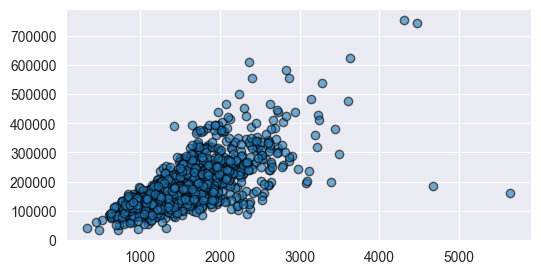

In [244]:
plt.figure(figsize=(6, 3))
plt.scatter(df['GrLivArea'], df['SalePrice'], alpha=0.6, edgecolor='k')

In [245]:
df = df[df.GrLivArea < 4000] # eliminate above 4000 sq. feet

Saving the data frame for later use.

In [246]:
# df.to_csv('train_preprocessed.csv')

Let's look at the dist of numerical features. It will help us identify for which features we might use log (or Box Cox) transformation.

In [247]:
numeric_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in df.columns if col not in numeric_cols]

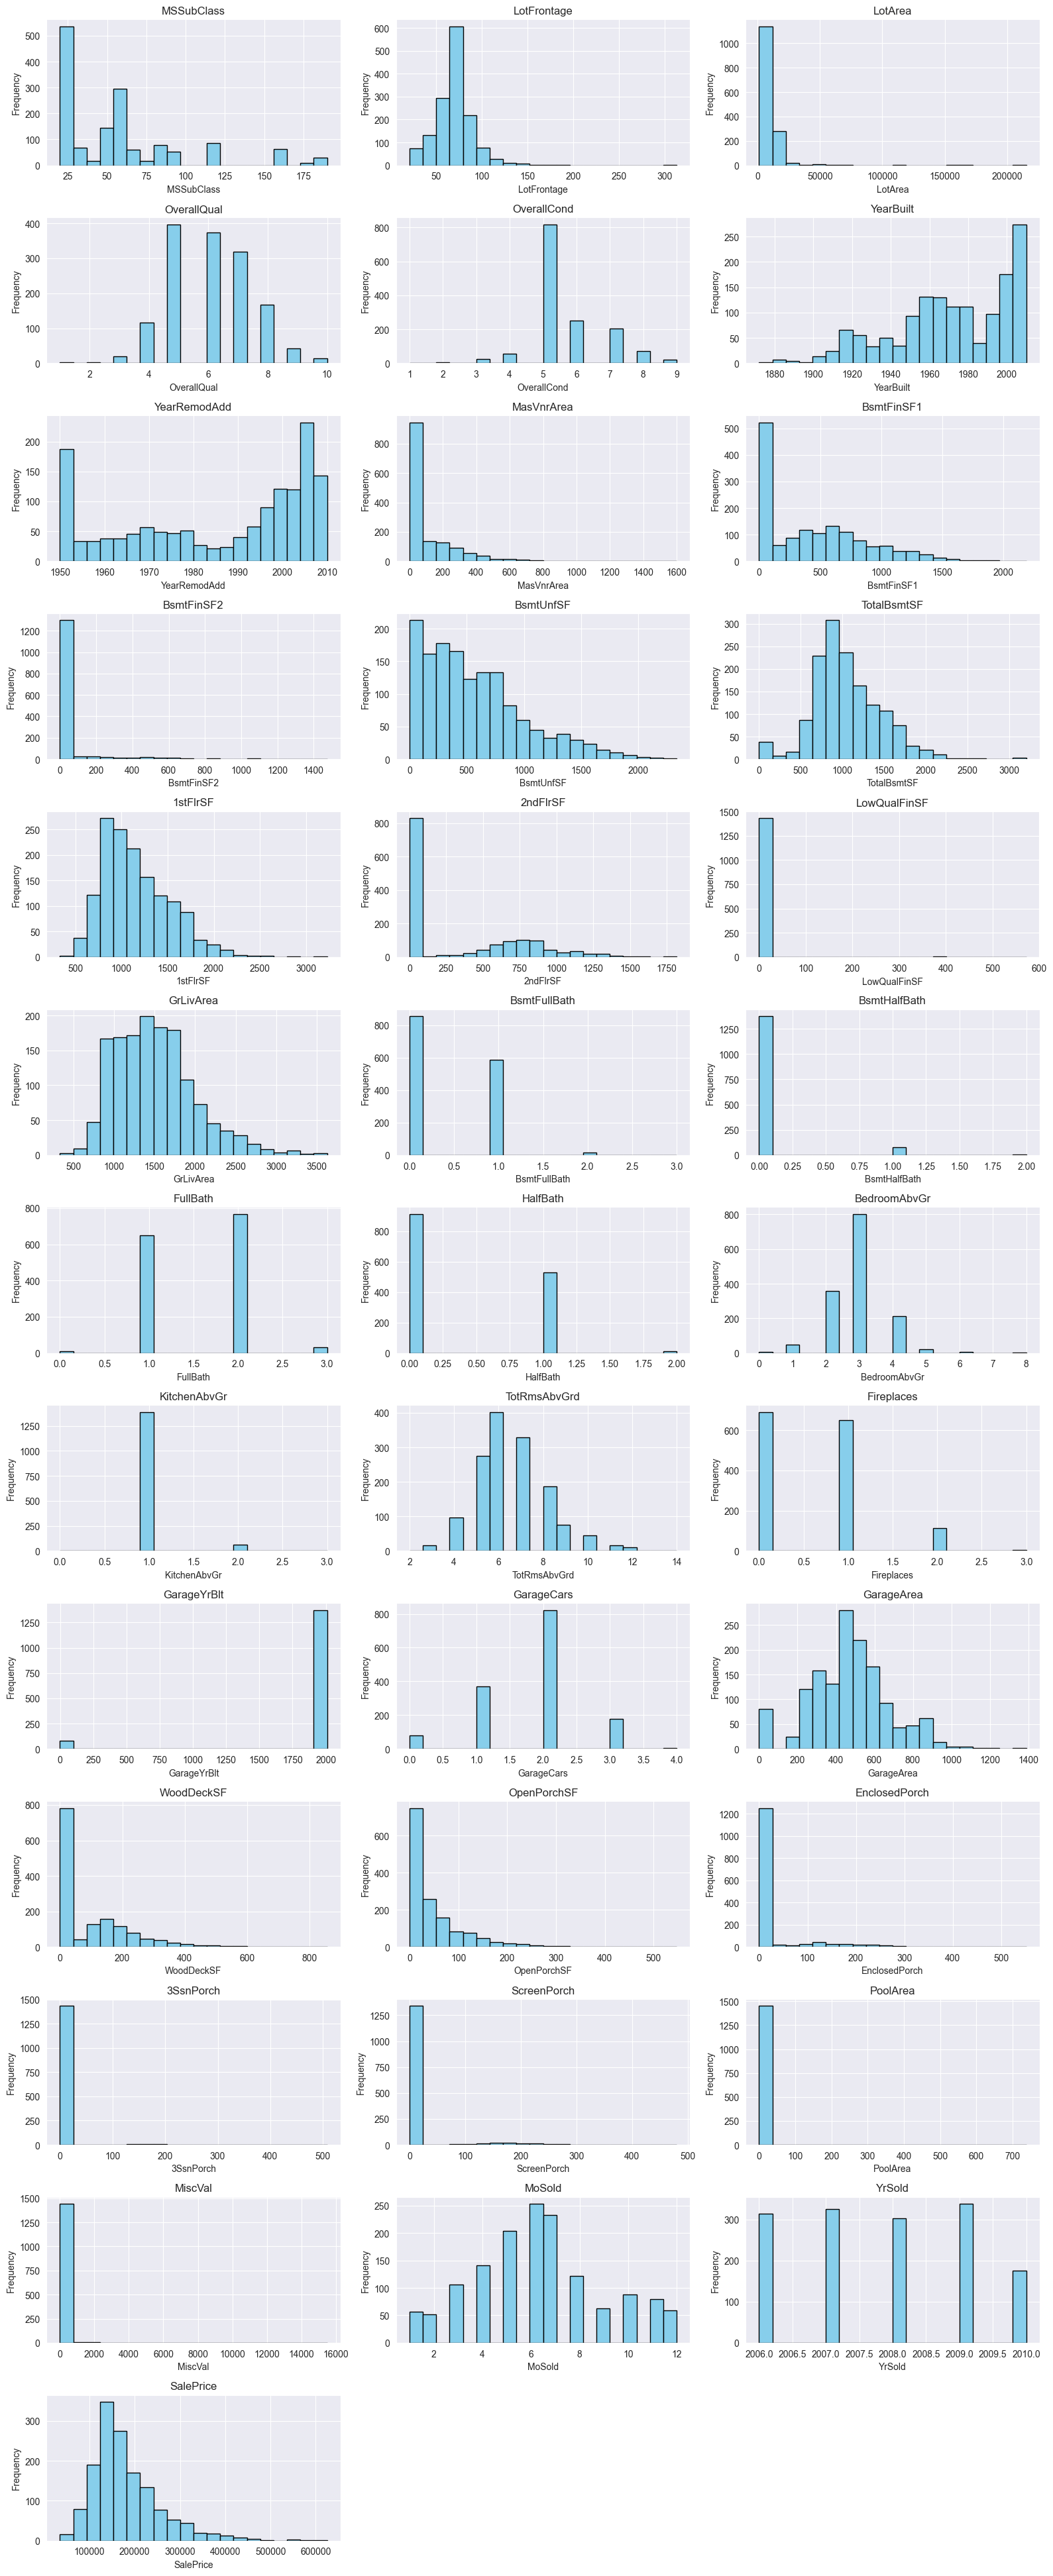

In [248]:
num_plots = len(numeric_cols)
cols = 3
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 3))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    df[col].plot(kind='hist', bins=20, ax=axes[i], title=col, color='skyblue', edgecolor='black')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We see quite a lot of highly skewed distributions. Will the transforamation help?

Lets create boxplots for numerical features

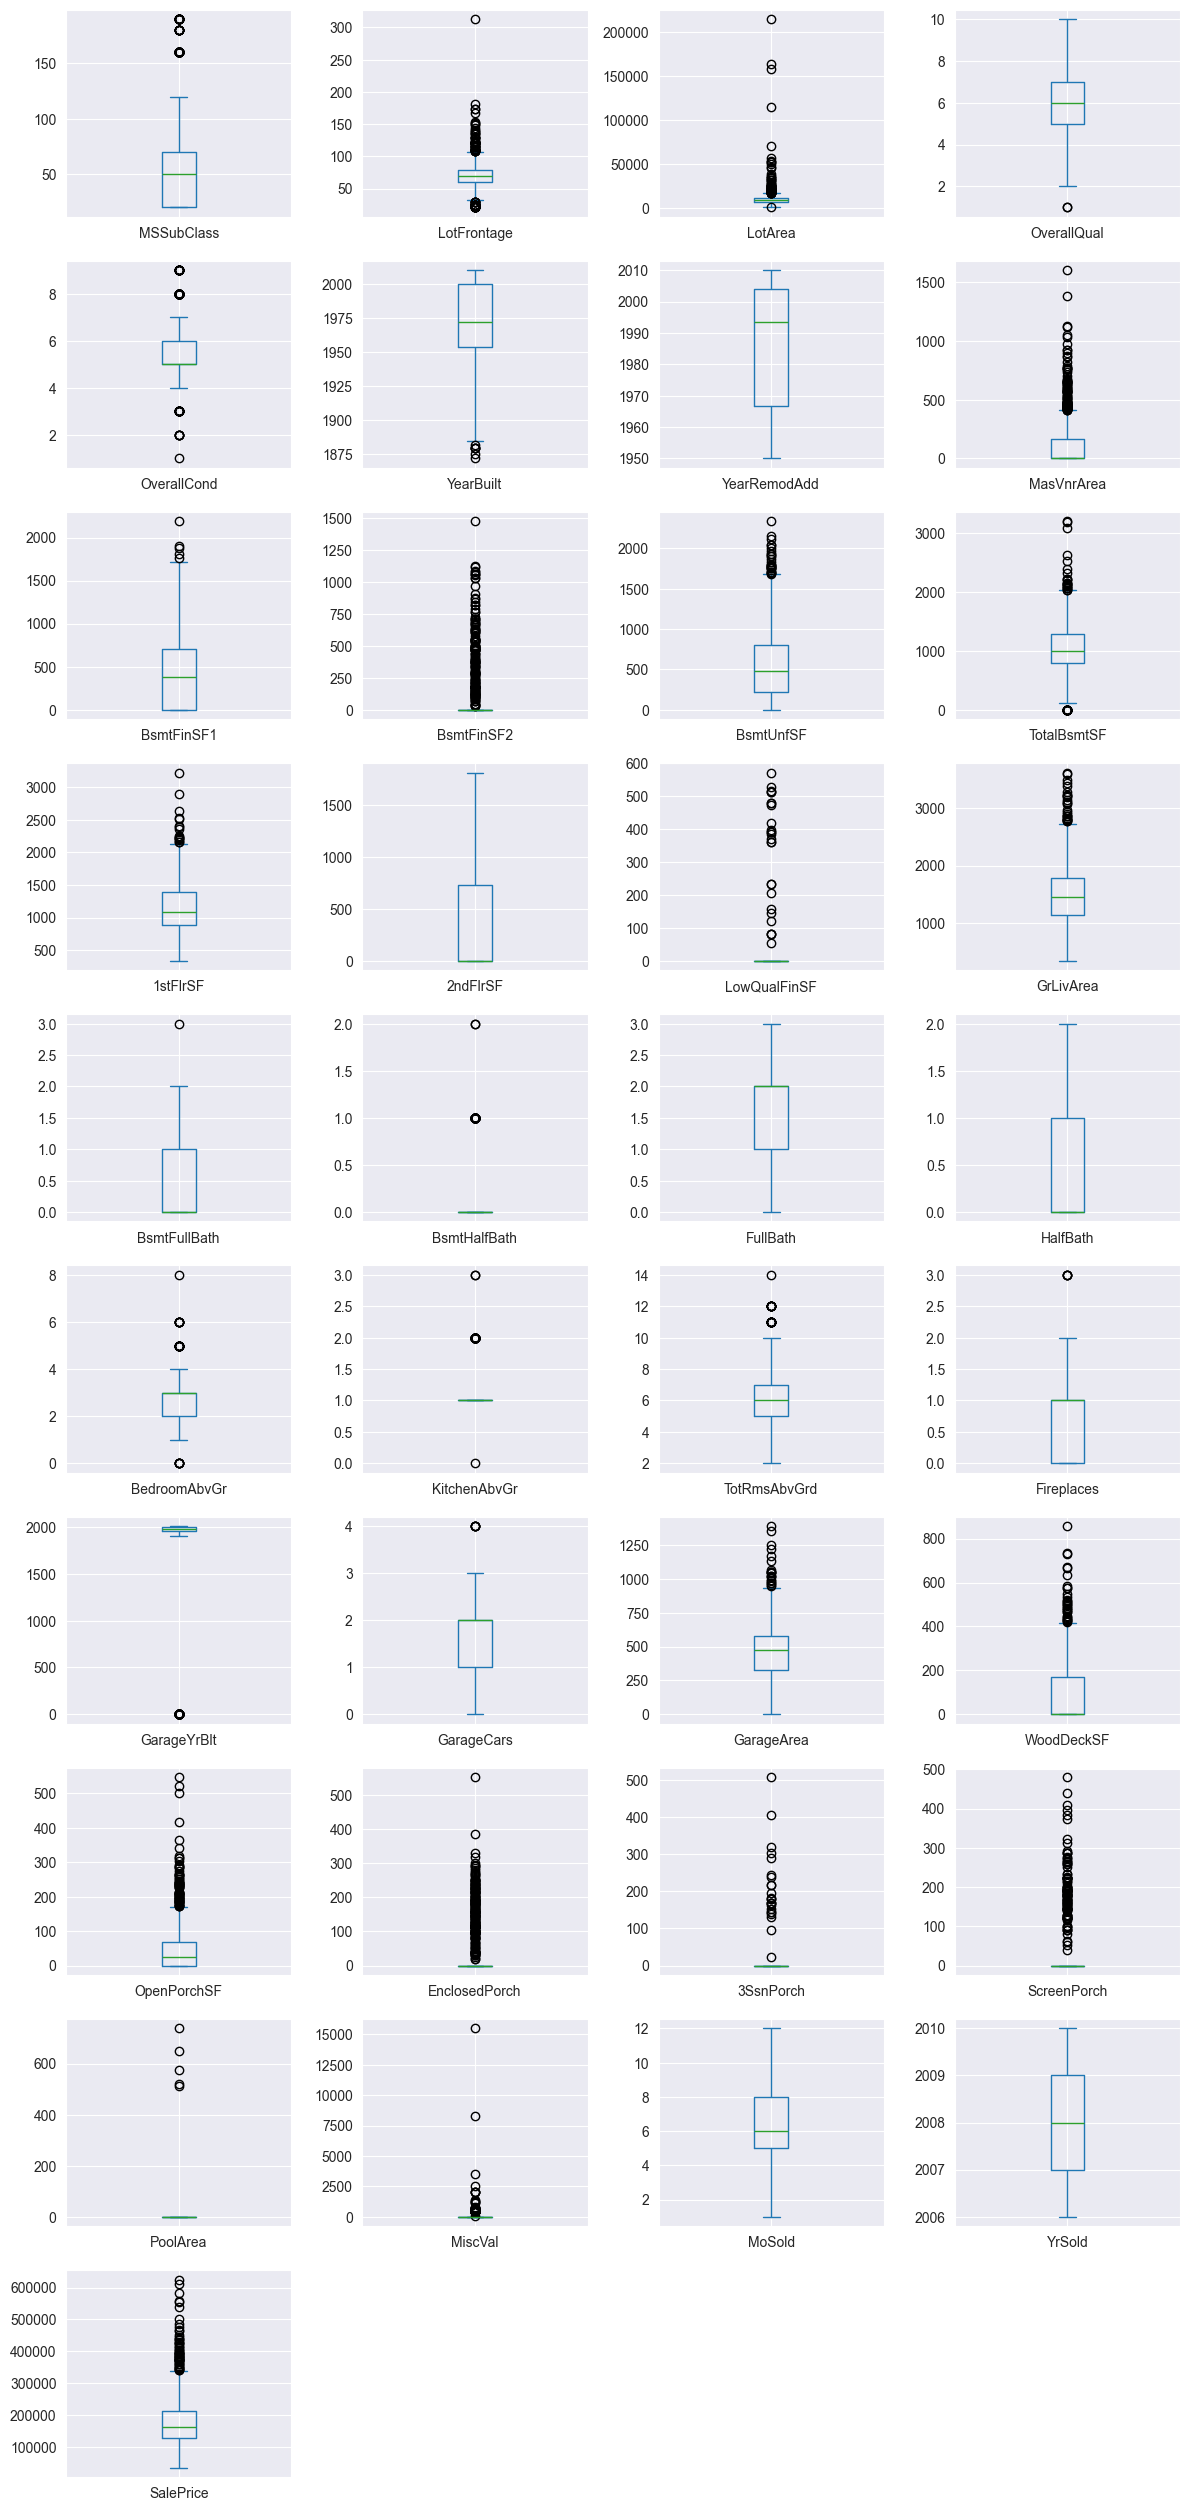

In [249]:
df[numeric_cols].plot(subplots=True, layout=(12,4), kind='box', figsize=(12, 30))
plt.tight_layout()
plt.show()

Correlations of the target variable with numerical features

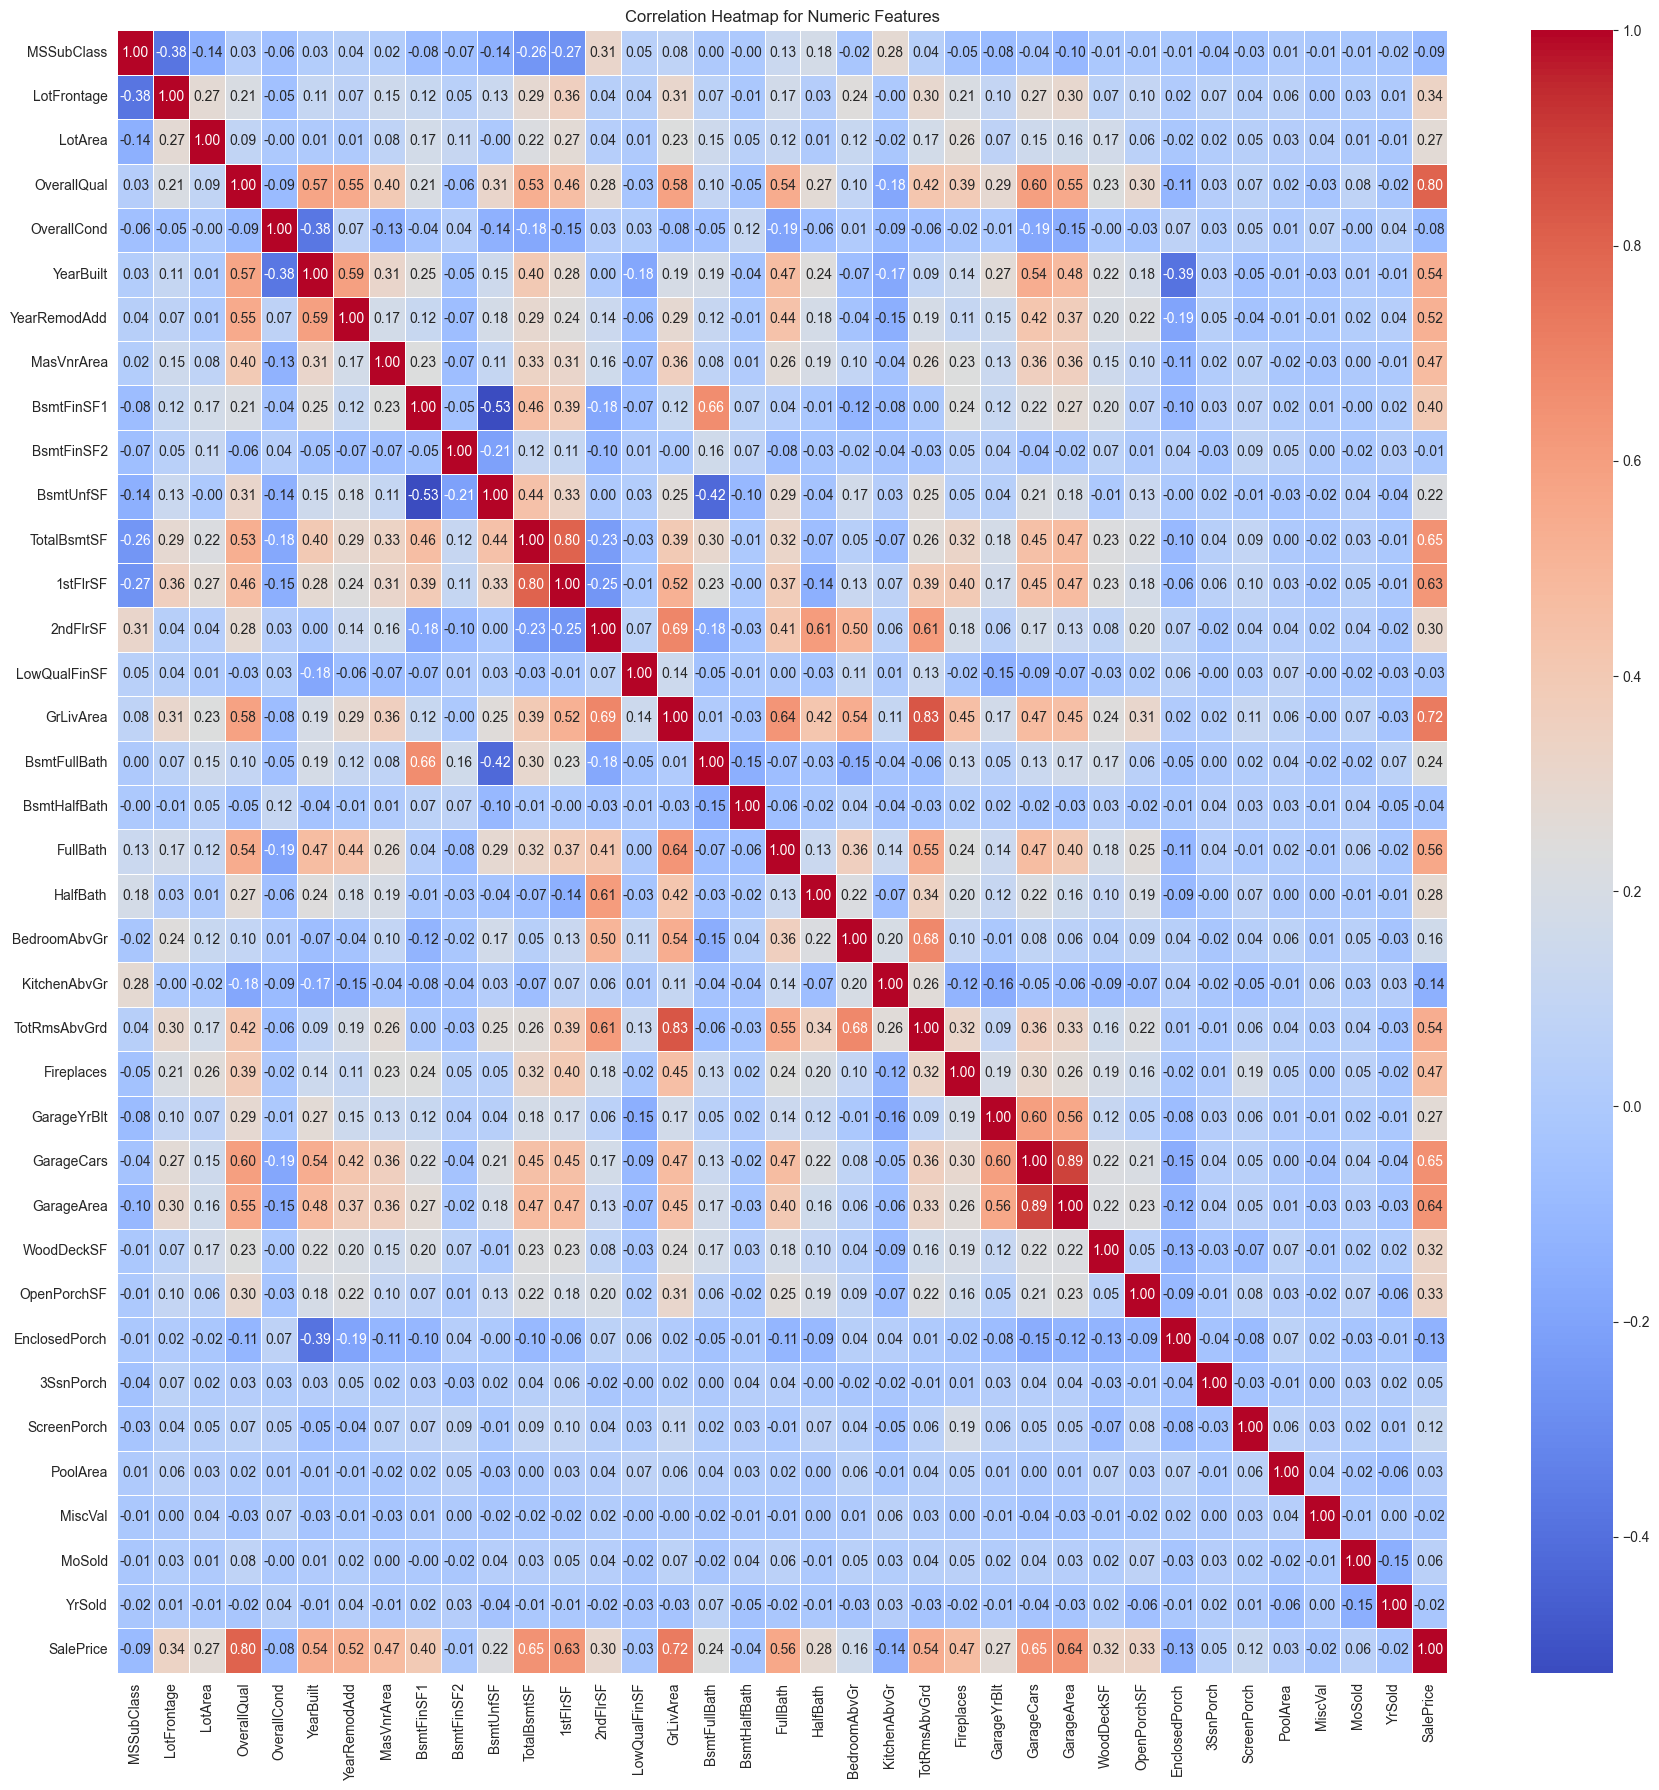

In [250]:
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap for Numeric Features")
plt.tight_layout()
plt.show()

Finding correlations above threshold

In [251]:
threshold = 0.5

upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
highly_correlated_pairs = highly_correlated_pairs[
    abs(highly_correlated_pairs['Correlation']) > threshold
]

In [252]:
highly_correlated_pairs.sort_values(by='Correlation', ascending=False) # high correlations above threshold

Feature 1     Feature 2  Correlation
600    GarageCars    GarageArea     0.886882
441     GrLivArea  TotRmsAbvGrd     0.833979
137   OverallQual     SalePrice     0.800858
341   TotalBsmtSF      1stFlrSF     0.800759
455     GrLivArea     SalePrice     0.720516
391      2ndFlrSF     GrLivArea     0.687430
531  BedroomAbvGr  TotRmsAbvGrd     0.679346
267    BsmtFinSF1  BsmtFullBath     0.661933
610    GarageCars     SalePrice     0.649256
365   TotalBsmtSF     SalePrice     0.646584
620    GarageArea     SalePrice     0.636964
437     GrLivArea      FullBath     0.635161
389      1stFlrSF     SalePrice     0.625235
398      2ndFlrSF  TotRmsAbvGrd     0.610794
395      2ndFlrSF      HalfBath     0.609022
126   OverallQual    GarageCars     0.598739
588   GarageYrBlt    GarageCars     0.598722
170     YearBuilt  YearRemodAdd     0.591906
116   OverallQual     GrLivArea     0.583519
106   OverallQual     YearBuilt     0.571712
589   GarageYrBlt    GarageArea     0.564445
512      FullBath     SalePrice     0.559048
127   OverallQual    GarageArea     0.554905
107   OverallQual  YearRemodAdd     0.550971
498      FullBath  TotRmsAbvGrd     0.549625
119   OverallQual      FullBath     0.543791
439     GrLivArea  BedroomAbvGr     0.540083
574  TotRmsAbvGrd     SalePrice     0.537462
189     YearBuilt    GarageCars     0.536749
200     YearBuilt     SalePrice     0.535279
112   OverallQual   TotalBsmtSF     0.532666
368      1stFlrSF     GrLivArea     0.522920
230  YearRemodAdd     SalePrice     0.521428
396      2ndFlrSF  BedroomAbvGr     0.502450
261    BsmtFinSF1     BsmtUnfSF    -0.526140

In [253]:
highly_correlated_pairs.loc[highly_correlated_pairs['Feature 2'] == 'SalePrice', :].sort_values(by='Correlation', ascending=False) # correlation with target 

Feature 1  Feature 2  Correlation
137   OverallQual  SalePrice     0.800858
455     GrLivArea  SalePrice     0.720516
610    GarageCars  SalePrice     0.649256
365   TotalBsmtSF  SalePrice     0.646584
620    GarageArea  SalePrice     0.636964
389      1stFlrSF  SalePrice     0.625235
512      FullBath  SalePrice     0.559048
574  TotRmsAbvGrd  SalePrice     0.537462
200     YearBuilt  SalePrice     0.535279
230  YearRemodAdd  SalePrice     0.521428

To identify which features to ordinary encode, we create these plots

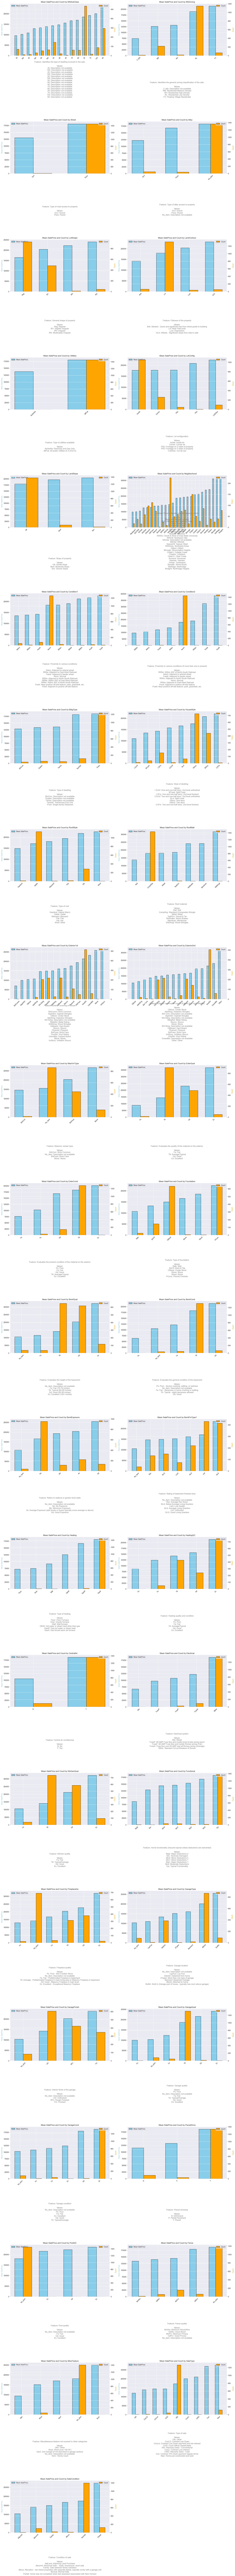

In [277]:
mean_comparison_results = {}
target_column = 'SalePrice'

num_plots = len(categorical_cols)
cols = 2
rows = ceil(num_plots / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 10))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    category_means = df.groupby(col)[target_column].mean()
    category_counts = df[col].value_counts()
    sorted_categories = category_means.sort_values().index
    sorted_means = category_means[sorted_categories]
    sorted_counts = category_counts[sorted_categories]
    mean_comparison_results[col] = sorted_means
    x = np.arange(len(sorted_categories))

    ax1 = axes[i]
    ax2 = ax1.twinx()

    bar_width = 0.35

    ax1.bar(x - bar_width / 2, sorted_means, width=bar_width, color='skyblue', edgecolor='black', label='Mean SalePrice')
    ax2.bar(x + bar_width / 2, sorted_counts, width=bar_width, color='orange', edgecolor='black', label='Count')

    ax1.set_title(f"Mean {target_column} and Count by {col}")
    ax1.set_xticks(x)
    ax1.set_xticklabels(sorted_categories, rotation=45)
    ax1.set_ylabel("Mean SalePrice", color='skyblue')
    ax2.set_ylabel("Count", color='orange')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    feature_description = feature_dict.get(col, {}).get("desc", "Description not available")
    value_descriptions = feature_dict.get(col, {}).get("values", {})
    sorted_value_desc_text = "\n".join(
        [f"{key}: {value_descriptions.get(key, 'Description not available')}" for key in sorted_categories]
    )

    full_description = f"Feature: {feature_description}\n\nValues:\n{sorted_value_desc_text}"

    ax1.text(
        0.5, -0.8, full_description, transform=ax1.transAxes, ha="center", fontsize=12, color="gray", wrap=True
    )

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We create .json file to store data about variables: their description and possible categories for categorical features

In [278]:
# # columns_dict, dict with dict with features and descriptions
# with open("columns_description.txt", "r") as file:
#     lines = file.readlines()
# 
# columns_dict = {}
# for line in lines:
#     if ": " in line:  # Ensure the line contains a key-value separator
#         key, value = line.strip().split(": ", 1)
#         columns_dict[key] = value
# 
# with open("columns_dict.json", "w") as json_file:
#     json.dump(columns_dict, json_file, indent=4)
# 
# structured_data = defaultdict(lambda: {"desc": "", "values": {}})
# 
# with open("data_description.txt", "r") as file:
#     lines = file.readlines()
# 
# current_feature = None
# 
# for line in lines:
#     feature_match = re.match(r"(\w+):\s+(.+)", line)
#     if feature_match:
#         current_feature = feature_match.group(1)
#         structured_data[current_feature]["desc"] = feature_match.group(2)
#     elif current_feature:
#         value_match = re.match(r"^\s*(\S+)\s+(.+)", line)
#         if value_match:
#             key = value_match.group(1)
#             value = value_match.group(2)
#             structured_data[current_feature]["values"][key] = value
# 
# structured_data = dict(structured_data)
# 
# with open("feature_dict.json", "w") as json_file:
#     json.dump(structured_data, json_file, indent=4)

In [279]:
ordinal_columns = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]

In [280]:
encoding_mappings = {}

for col in ordinal_columns:
    if col in df.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        encoding_mappings[col] = mapping

In [281]:
encoding_mappings

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1},
 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1},
 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1},
 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1},
 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1},
 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}

## 3. Evaluation

3.1 Importing dictionaries and data

In [282]:
with open("feature_dict.json", "r") as json_file:
    feature_dict = json.load(json_file)

In [283]:
df = pd.read_csv('train_prepared_for_cv.csv')

In [284]:
sum(df.isna().sum())

357

In [285]:
X = df.drop(columns=['Id', 'SalePrice'])
y = df['SalePrice']

In [286]:
numeric_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
numeric_cols.remove("MSSubClass")
categorical_cols = [col for col in X.columns if col not in numeric_cols]
ordinal_encode_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", "HeatingQC", "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC", "Street", "Alley", "PavedDrive"]
label_encode_cols = [col for col in categorical_cols if col not in ordinal_encode_cols]
ohe_encode_cols = label_encode_cols

Numerical columns

In [287]:
print(numeric_cols)

['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


Categorical columns

In [288]:
print(categorical_cols)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


Ordinal columns

In [289]:
print(ordinal_encode_cols)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'Street', 'Alley', 'PavedDrive']


Label/OHE encode columns

In [290]:
print(label_encode_cols)

['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtFinType1', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [291]:
print(len(categorical_cols))
print(len(ordinal_encode_cols), len(label_encode_cols), len(ohe_encode_cols))
print(len(ordinal_encode_cols) + len(label_encode_cols))
print(len(numeric_cols))
print(len(numeric_cols) + len(categorical_cols))

43
14 29 29
43
35
78


### 3.2 Creating mappings for categorical columns

Since some of the columns does not have all the categories, we create mappings. It will also help us to ensure correct mappings on cross validation, so we won't miss any categories due to their absence on a particular fold.

In [292]:
ordinal_mappings = {}

for col in ordinal_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        ordinal_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def ordinal_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = X.apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(ordinal_mappings)

{'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'ExterCond': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'BsmtQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'BsmtExposure': {'No': 2, 'Mn': 3, 'Av': 4, 'Gd': 5, 'No_item': -1}, 'HeatingQC': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'KitchenQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'FireplaceQu': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageQual': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'GarageCond': {'Po': 2, 'Fa': 3, 'TA': 4, 'Gd': 5, 'Ex': 6, 'No_item': -1}, 'PoolQC': {'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'No_item': -1}, 'Street': {'Grvl': 1, 'Pave': 2, 'No_item': -1}, 'Alley': {'Grvl': 2, 'Pave': 3, 'No_item': -1}, 'PavedDrive': {'N': 1, 'P': 2, 'Y': 3, 'No_item': -1}}


In [293]:
label_mappings = {}

for col in label_encode_cols:
    if col in X.columns and col in feature_dict:
        all_values = list(feature_dict[col]["values"].keys())
        mapping = {category: rank for rank, category in enumerate(reversed(all_values), start=1)}
        mapping["No_item"] = -1
        if "NA" in mapping.keys():
            del mapping["NA"]
        label_mappings[col] = mapping
        
def safe_map(value, mapping):
    if value not in mapping:
        raise ValueError(f"Value '{value}' not found in the mapping!")
    return mapping[value]

def label_encode_column(X, mappings):
    encoded = X.copy()
    for col in X.columns:
        if col in mappings:
            encoded[col] = df[col].apply(lambda x: safe_map(x, mappings[col]))
    return encoded

print(label_mappings)

{'MSSubClass': {'190': 1, '180': 2, '160': 3, '150': 4, '120': 5, '90': 6, '85': 7, '80': 8, '75': 9, '70': 10, '60': 11, '50': 12, '45': 13, '40': 14, '30': 15, '20': 16, 'No_item': -1}, 'MSZoning': {'RM': 1, 'RP': 2, 'RL': 3, 'RH': 4, 'I': 5, 'FV': 6, 'C': 7, 'A': 8, 'No_item': -1}, 'LotShape': {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4, 'No_item': -1}, 'LandContour': {'Low': 1, 'HLS': 2, 'Bnk': 3, 'Lvl': 4, 'No_item': -1}, 'Utilities': {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4, 'No_item': -1}, 'LotConfig': {'FR3': 1, 'FR2': 2, 'CulDSac': 3, 'Corner': 4, 'Inside': 5, 'No_item': -1}, 'LandSlope': {'Sev': 1, 'Mod': 2, 'Gtl': 3, 'No_item': -1}, 'Neighborhood': {'Veenker': 1, 'Timber': 2, 'StoneBr': 3, 'Somerst': 4, 'SawyerW': 5, 'Sawyer': 6, 'SWISU': 7, 'OldTown': 8, 'NWAmes': 9, 'NridgHt': 10, 'NPkVill': 11, 'NoRidge': 12, 'Names': 13, 'Mitchel': 14, 'MeadowV': 15, 'IDOTRR': 16, 'Gilbert': 17, 'Edwards': 18, 'Crawfor': 19, 'CollgCr': 20, 'ClearCr': 21, 'BrkSide': 22, 'BrDale': 23, 

### 3.3 Creating functions and classes for evaluation and training

In [294]:
class DataFramePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, ordinal_cols, ohe_cols, label_cols, ordinal_mappings, label_mappings, features_to_scale):
        self.numeric_cols = numeric_cols
        self.ordinal_cols = ordinal_cols
        self.ohe_cols = ohe_cols
        self.label_cols = label_cols
        self.ordinal_mappings = ordinal_mappings
        self.label_mappings = label_mappings
        self.ohe_columns_names = None
        self.medians = {}
        self.modes = {}
        self.scaler = StandardScaler()
        self.features_to_scale = features_to_scale

    def fit(self, X, y=None):
        self.medians = X[self.numeric_cols].median()
        self.modes = X[self.ordinal_cols + self.ohe_cols + self.label_cols].mode().iloc[0]
        if self.ohe_cols:
            self.ohe_columns_names = []
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        self.ohe_columns_names.append(f"{col}_{category}")
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
        return self

    def transform(self, X):
        X = X.copy()
        # filling NA
        for col in self.numeric_cols:
            X[col] = X[col].fillna(self.medians[col])
        
        # skewness = X[numeric_cols].apply(lambda x: skew(x))
        # skewness = skewness[abs(skewness) > 0.5]
        # skewed_features = skewness.index
        # X[skewed_features] = np.log1p(X[skewed_features])
    
        if X.columns.duplicated().any():
                raise ValueError(f"Duplicate column names found: {X.columns[X.columns.duplicated()].tolist()}")

        for col in self.ordinal_cols + self.ohe_cols + self.label_cols:
            X[col] = X[col].fillna(self.modes[col])
        
        for col in self.ordinal_cols:
            if col in self.ordinal_mappings:
                X[col] = X[col].map(self.ordinal_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        for col in self.label_cols:
            if col in self.label_mappings:
                X[col] = X[col].map(self.label_mappings[col]).fillna(-1)
            else:
                raise KeyError
        
        if self.features_to_scale:
            X[self.features_to_scale] = self.scaler.fit_transform(X[self.features_to_scale])

        
        if self.ohe_cols:
            ohe_encoded = pd.DataFrame(0, index=X.index, columns=self.ohe_columns_names)
            for col in self.ohe_cols:
                if col in feature_dict:
                    categories = feature_dict[col]["values"].keys()
                    for category in categories:
                        ohe_col_name = f"{col}_{category}"
                        ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
                else:
                    raise KeyError(f"Feature {col} not found in feature dictionary")
                
            X = X.drop(columns=self.ohe_cols)
            X = pd.concat([X, ohe_encoded], axis=1)
            
        return X

In [295]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=ohe_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [296]:
# testing preprocessing
processed_data = preprocessor.fit_transform(X)

Initializing features that have high skewness from our previous analysis. The performance on log transformed features was worse, so we decided not to use it.

In [297]:
# These feature have skewness > 0.5
# skewed_cols = ['LotFrontage', 'LotArea', 'OverallCond', 'YearBuilt', 'MasVnrArea',
#        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', '1stFlrSF', '2ndFlrSF',
#        'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
#        'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
#        'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
#        'ScreenPorch', 'PoolArea', 'MiscVal']

In [298]:
processed_data

LotFrontage   LotArea    Street     Alley  OverallQual  OverallCond  \
0       -0.218699 -0.202770  0.064327 -0.255382     0.665646    -0.517461   
1        0.499122 -0.086107  0.064327 -0.255382    -0.064709     2.176545   
2       -0.075135  0.081281  0.064327 -0.255382     0.665646    -0.517461   
3       -0.457972 -0.091179  0.064327 -0.255382     0.665646    -0.517461   
4        0.690541  0.386636  0.064327 -0.255382     1.396000    -0.517461   
...           ...       ...       ...       ...          ...          ...   
1451    -0.362263 -0.256842  0.064327 -0.255382    -0.064709    -0.517461   
1452     0.738396  0.276566  0.064327 -0.255382    -0.064709     0.380541   
1453    -0.170844 -0.142714  0.064327 -0.255382     0.665646     3.074547   
1454    -0.075135 -0.074237  0.064327 -0.255382    -0.795063     0.380541   
1455     0.259849 -0.051919  0.064327 -0.255382    -0.795063     0.380541   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  SaleType_ConLw  \
0      1.053769      0.880629    0.533895   1.066349  ...               0   
1      0.159469     -0.427190   -0.573757  -0.688006  ...               0   
2      0.987524      0.832191    0.341751   1.066349  ...               0   
3     -1.860986     -0.717817   -0.573757  -0.688006  ...               0   
4      0.954402      0.735316    1.404192   1.066349  ...               0   
...         ...           ...         ...        ...  ...             ...   
1451   0.921280      0.735316   -0.573757  -0.688006  ...               0   
1452   0.225713      0.154063    0.098746  -0.688006  ...               0   
1453  -0.999809      1.025942   -0.573757   2.820705  ...               0   
1454  -0.701709      0.541565   -0.573757  -0.688006  ...               0   
1455  -0.204875     -0.960006   -0.573757   1.066349  ...               0   

      SaleType_ConLI  SaleType_ConLD  SaleType_Oth  SaleCondition_Normal  \
0                  0               0             0                     1   
1                  0               0             0                     1   
2                  0               0             0                     1   
3                  0               0             0                     0   
4                  0               0             0                     1   
...              ...             ...           ...                   ...   
1451               0               0             0                     1   
1452               0               0             0                     1   
1453               0               0             0                     1   
1454               0               0             0                     1   
1455               0               0             0                     1   

      SaleCondition_Abnorml  SaleCondition_AdjLand  SaleCondition_Alloca  \
0                         0                      0                     0   
1                         0                      0                     0   
2                         0                      0                     0   
3                         1                      0                     0   
4                         0                      0                     0   
...                     ...                    ...                   ...   
1451                      0                      0                     0   
1452                      0                      0                     0   
1453                      0                      0                     0   
1454                      0                      0                     0   
1455                      0                      0                     0   

      SaleCondition_Family  SaleCondition_Partial  
0                        0                      0  
1                        0                      0  
2                        0                      0  
3                        0                      0  
4                        0                      0  
...               

Creating a function to train and validate models on cross-validation.

In [299]:
def run_model(model_class, param_grid, preprocessor, X, y):
    
    kf = KFold(n_splits=9, shuffle=True, random_state=42)
    
    r2 = {"train": [], "test": []}
    mae = {"train": [], "test": []}
    best_params = []
    feature_importances = pd.DataFrame(index=preprocessor.fit_transform(X).columns)

    for fold, (train_index, test_index) in tqdm(enumerate(kf.split(X), 1)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        preprocessor.fit(X_train)
        X_train_preprocessed = preprocessor.transform(X_train)
        X_test_preprocessed = preprocessor.transform(X_test)
                
        model = model_class()
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
        grid_search.fit(X_train_preprocessed, y_train)
        
        best_params.append(grid_search.best_params_)
        
        model = model_class(**grid_search.best_params_)
        model.fit(X_train_preprocessed, y_train)
        
        y_train_pred = model.predict(X_train_preprocessed)
        y_test_pred = model.predict(X_test_preprocessed)
        
        train_mae = mean_absolute_error(y_train, y_train_pred)
        test_mae = mean_absolute_error(y_test, y_test_pred)
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        
        r2["train"].append(train_r2)
        r2["test"].append(test_r2)
        mae["train"].append(train_mae)
        mae["test"].append(test_mae)
        
        # if hasattr(model, "coef_"):
        #     print(f"Model {model_class} has coef_ attribute")
        #     print(model.coef_)
        # if hasattr(model, "feature_importances_"):
        #     print(f"Model {model_class} has feature_importances_ attribute")
        #     print(model.feature_importances_)
        
        if model_class == XGBRegressor:
            gain_importance = model.get_booster().get_score(importance_type='gain')
            fold_importances = pd.Series(gain_importance)
        else:
            if hasattr(model, "coef_"):
                try:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X.columns)
                except:
                    fold_importances = pd.Series(np.abs(model.coef_), index=X_train_preprocessed.columns)
                    
            elif hasattr(model, "feature_importances_"):    
                try:
                    fold_importances = pd.Series(model.feature_importances_, index=X.columns)
                except:
                    fold_importances = pd.Series(model.feature_importances_, index=X_train_preprocessed.columns)
            else:
                raise AttributeError(f"The model {model_class.__name__} does not support feature importance extraction.")
            
        common_indices = set(feature_importances.index) & set(fold_importances.index)
        if not common_indices:
            raise ValueError("No corresponding string indices found in the left DataFrame.")
        # feature_importances = pd.concat([feature_importances, fold_importances], axis=1)
        feature_importances = feature_importances.merge(fold_importances.rename(f"{fold}"), left_index=True, right_index=True, how='outer')
        
    
    feature_importances['mean_importance'] = feature_importances.mean(axis=1)
    feature_importances = feature_importances[['mean_importance']].sort_values(by='mean_importance', ascending=False)
    
    return pd.DataFrame(r2), pd.DataFrame(mae), feature_importances, best_params

### 3.4 Model evaluating

Dictionary to store the results:

In [300]:
models_dict = {}
models_dict["XGBRegressor"] = []
models_dict["Lasso"] = []
models_dict["ElasticNet"] = []
models_dict["LinearRegression"] = []
models_dict["OLS"] = []
models_dict["RFELinearRegression"] = []
models_dict["RFE"] = []

#### 3.4.1 Label Encoding without scaling:

In [339]:
import os
sys.stderr = open(os.devnull, 'w')

In [340]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)

In [341]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0, 0.5, 1],
#     'nthread': [-1],
# }

param_grid = {'learning_rate': [0.1], 'max_depth': [3], 'n_estimators': [300], 'nthread': [-1], 'reg_alpha': [1], 'reg_lambda': [0.5], 'subsample': [0.8]}

# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)

models_dict["XGBRegressor"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [342]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [343]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [344]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

models_dict["OLS"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": None,
    "mean_r2": 0.901,
    "best_params": None,
    "feature_importance": model.pvalues[model.pvalues < 0.05].sort_values()
})

P-values:
MSSubClass       6.001855e-01
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
Street           5.725043e-02
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 78, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:56:21   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [345]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "label",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [346]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [347]:
len(rfecv.support_) # does not really select any

78

#### 3.4.2 Label Encoding with scaling

In [348]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=[],
    label_cols=label_encode_cols,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols + label_encode_cols
)
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [349]:
feature_importances

mean_importance
GrLivArea       25904.030800
OverallQual     15413.213177
TotalBsmtSF      8872.317848
BsmtFinSF1       8569.100592
ExterQual        7517.498570
...                      ...
HouseStyle          0.000000
LandSlope           0.000000
LotConfig           0.000000
MSSubClass          0.000000
YrSold              0.000000

[78 rows x 1 columns]

In [350]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [351]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [352]:
X_preprocessed = preprocessor.transform(X)

X_with_const = sm.add_constant(X_preprocessed)
model = sm.OLS(y, X_with_const).fit()

p_values = model.pvalues
print("P-values:")
print(p_values)

print(model.summary())

models_dict["OLS"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": None,
    "mean_r2": 0.901,
    "best_params": None,
    "feature_importance": model.pvalues[model.pvalues < 0.05].sort_values()
})

P-values:
const            0.000000e+00
MSSubClass       4.582833e-02
MSZoning         1.520540e-03
LotFrontage      9.832074e-03
LotArea          2.011993e-09
                     ...     
MiscVal          9.921771e-01
MoSold           4.828913e-01
YrSold           8.650006e-01
SaleType         4.853411e-01
SaleCondition    2.869239e-07
Length: 79, dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     166.6
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        01:56:56   Log-Likelihood:                -16762.
No. Observations:                1456   AIC:                         3.368e+04
Df Residuals:                    1380   BIC:                         3.408e+04
D

In [353]:
# stepwise
X_preprocessed = preprocessor.fit_transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2')

In [354]:
X_preprocessed.columns[rfecv.support_]

Index(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea'],
      dtype='object')

In [355]:
models_dict["RFE"].append({
    "encoding": "label",
    "scaling": True,
    "mean_mae": None,
    "mean_r2": None,
    "best_params": None,
    "feature_importance": X_preprocessed.columns[rfecv.support_]
})

In [356]:
selected_cols = list(X_preprocessed.columns[rfecv.support_])

numeric_cols_selected = []
ordinal_encode_cols_selected = []
label_encode_cols_selected = []

for col in selected_cols:
    if col in numeric_cols:
        numeric_cols_selected.append(col)
    if col in ordinal_encode_cols:
        ordinal_encode_cols_selected.append(col)
    if col in label_encode_cols:
        label_encode_cols_selected.append(col)

In [357]:
preprocessor_for_selected = DataFramePreprocessor(
    numeric_cols=numeric_cols_selected,
    ordinal_cols=ordinal_encode_cols_selected,
    ohe_cols=[],
    label_cols=label_encode_cols_selected,
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols_selected + label_encode_cols_selected + label_encode_cols
)

#### 3.4.3 Label Encoding with scaling

In [358]:
# getting features on non scaled data for xgboost
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=[]
)
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 9],
#     'learning_rate': [0.01, 0.1],
#     'subsample': [0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0, 0.5, 1],
#     'nthread': [-1],
# }

param_grid = {'learning_rate': [0.1], 'max_depth': [3], 'n_estimators': [300], 'nthread': [-1], 'reg_alpha': [1], 'reg_lambda': [1], 'subsample': [0.8]}


# Run the model
r2, mae, feature_importances, best_params = run_model(
    model_class=XGBRegressor, 
    param_grid=param_grid, 
    preprocessor=preprocessor, 
    X=X, 
    y=y
)

models_dict["XGBRegressor"].append({
    "encoding": "ohe",
    "scaling": False,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

# print(best_params)

0it [00:00, ?it/s]

In [359]:
feature_importances / feature_importances["mean_importance"].sum()

mean_importance
OverallQual              0.189591
GarageCars               0.122219
ExterQual                0.105924
BsmtQual                 0.035124
GrLivArea                0.034249
...                           ...
SaleType_VWD                  NaN
Utilities_AllPub              NaN
Utilities_ELO                 NaN
Utilities_NoSeWa              NaN
Utilities_NoSewr              NaN

[274 rows x 1 columns]

Global Feature Importance:


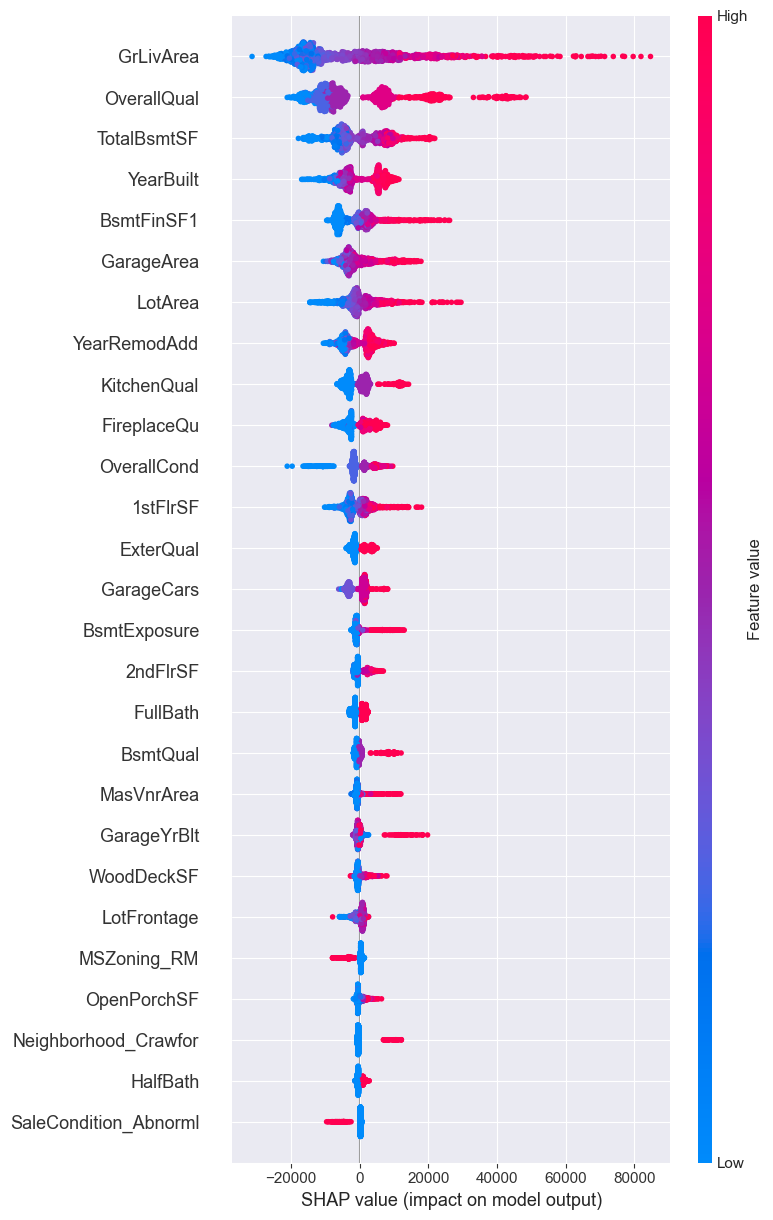

In [360]:
import shap

X_preprocessed = preprocessor.fit_transform(X)
model = XGBRegressor(objective='reg:absoluteerror', learning_rate=0.1, max_depth=3, n_estimators=300, nthread=-1, reg_alpha=1, reg_lambda=1, subsample=0.8)
model.fit(X_preprocessed, y)

explainer = shap.Explainer(model, X_preprocessed)

shap_values = explainer(X_preprocessed)

# Visualize Global Feature Importance
print("Global Feature Importance:")
shap.summary_plot(shap_values, X_preprocessed, max_display=int(X_preprocessed.shape[1] * 0.1))

In [361]:
# scaling for regressions

preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)

In [362]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
r2, mae, feature_importances, best_params = run_model(model_class=Lasso, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["Lasso"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [363]:
param_grid = {}
r2, mae, feature_importances, best_params = run_model(model_class=LinearRegression, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["LinearRegression"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [364]:
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]      
}
r2, mae, feature_importances, best_params = run_model(model_class=ElasticNet, param_grid=param_grid, preprocessor=preprocessor, X=X, y=y)

models_dict["ElasticNet"].append({
    "encoding": "ohe",
    "scaling": True,
    "mean_mae": mae.mean(),
    "mean_r2": r2.mean(),
    "best_params": best_params,
    "feature_importance": feature_importances
})

0it [00:00, ?it/s]

In [365]:
# stepwise
X_preprocessed = preprocessor.transform(X)

model = LinearRegression()

cv = KFold(n_splits=9, shuffle=True, random_state=42)

rfecv = RFECV(estimator=model, step=3, cv=cv, scoring='r2')
rfecv.fit(X_preprocessed, y)

RFECV(cv=KFold(n_splits=9, random_state=42, shuffle=True),
      estimator=LinearRegression(), scoring='r2', step=3)

In [366]:
ohe_cols = ohe_encode_cols
ohe_columns_names = []
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_columns_names.append(f"{col}_{category}")
            
ohe_encoded = pd.DataFrame(0, index=X.index, columns=ohe_columns_names)
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_col_name = f"{col}_{category}"
            ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)
absent_columns = ohe_encoded.columns[(ohe_encoded == 0).all()]

In [367]:
preprocessor = DataFramePreprocessor(
    numeric_cols=numeric_cols,
    ordinal_cols=ordinal_encode_cols,
    ohe_cols=label_encode_cols,
    label_cols=[],
    ordinal_mappings=ordinal_mappings,
    label_mappings=label_mappings,
    features_to_scale=numeric_cols + ordinal_encode_cols
)
X_preprocessed = preprocessor.fit_transform(X)


In [368]:
X_preprocessed = X_preprocessed.drop(columns=absent_columns)

In [369]:
X_preprocessed.shape

(1456, 228)

In [370]:
mi_scores_dict = {}

for k in [3, 5, 10, 20]:
    mi_scores = mutual_info_regression(X_preprocessed, y, n_neighbors=k)
    mi_scores_dict[k] = pd.Series(mi_scores, index=[X_preprocessed.columns]).sort_values(ascending=False)

mi_scores_df = pd.DataFrame(mi_scores_dict)

In [371]:
mi_scores_df[5].sort_values(ascending=False)

OverallQual             0.571626
GrLivArea               0.470503
TotalBsmtSF             0.374880
GarageCars              0.365204
GarageArea              0.354935
                          ...   
Neighborhood_Blueste    0.000000
Functional_Sev          0.000000
MoSold                  0.000000
MiscFeature_TenC        0.000000
Functional_Typ          0.000000
Name: 5, Length: 228, dtype: float64

In [372]:
mi_scores_df[5].sort_values(ascending=False) / mi_scores_df[5].sort_values(ascending=False).sum()

OverallQual             0.055144
GrLivArea               0.045389
TotalBsmtSF             0.036164
GarageCars              0.035231
GarageArea              0.034240
                          ...   
Neighborhood_Blueste    0.000000
Functional_Sev          0.000000
MoSold                  0.000000
MiscFeature_TenC        0.000000
Functional_Typ          0.000000
Name: 5, Length: 228, dtype: float64

In [373]:
(mi_scores_df[5].sort_values(ascending=False) == 0).sum()

np.int64(60)

### Comparing

In [171]:
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["encoding"], model_1["scaling"])
        print("MAE:\n", model_1["mean_mae"])
        print("R2:\n", model_1["mean_r2"])
        

        
    print("-"*100)

XGBRegressor
label False
MAE:
 train     6517.336458
test     14499.451517
dtype: float64
R2:
 train    0.987680
test     0.912829
dtype: float64
ohe False
MAE:
 train     6605.077882
test     14291.403792
dtype: float64
R2:
 train    0.987042
test     0.917875
dtype: float64
----------------------------------------------------------------------------------------------------
Lasso
label False
MAE:
 train    17337.069397
test     18225.590336
dtype: float64
R2:
 train    0.893988
test     0.879915
dtype: float64
label True
MAE:
 train    17351.442454
test     19308.888014
dtype: float64
R2:
 train    0.891875
test     0.869896
dtype: float64
ohe True
MAE:
 train    15154.029586
test     18055.670719
dtype: float64
R2:
 train    0.91981
test     0.89023
dtype: float64
----------------------------------------------------------------------------------------------------
ElasticNet
label False
MAE:
 train    17123.594659
test     18154.145048
dtype: float64
R2:
 train    0.897390
test     0.

In [172]:
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["best_params"])
    print("-"*100)

XGBRegressor
[{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alpha': 1, 'reg_lambda': 0.5, 'subsample': 0.8}, {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'nthread': -1, 'reg_alp

In [173]:
# models_dict["ElasticNet"][0]["feature_importance"]
for model in models_dict.keys():
    print(model)
    for model_1 in models_dict[model]:
        print(model_1["encoding"], model_1["scaling"])
        print("MAE:\n", model_1["mean_mae"])
        print("R2:\n", model_1["mean_r2"])

XGBRegressor
label False
MAE:
 train     6517.336458
test     14499.451517
dtype: float64
R2:
 train    0.987680
test     0.912829
dtype: float64
ohe False
MAE:
 train     6605.077882
test     14291.403792
dtype: float64
R2:
 train    0.987042
test     0.917875
dtype: float64
Lasso
label False
MAE:
 train    17337.069397
test     18225.590336
dtype: float64
R2:
 train    0.893988
test     0.879915
dtype: float64
label True
MAE:
 train    17351.442454
test     19308.888014
dtype: float64
R2:
 train    0.891875
test     0.869896
dtype: float64
ohe True
MAE:
 train    15154.029586
test     18055.670719
dtype: float64
R2:
 train    0.91981
test     0.89023
dtype: float64
ElasticNet
label False
MAE:
 train    17123.594659
test     18154.145048
dtype: float64
R2:
 train    0.897390
test     0.882047
dtype: float64
label True
MAE:
 train    17178.045438
test     19545.178831
dtype: float64
R2:
 train    0.893722
test     0.869004
dtype: float64
ohe True
MAE:
 train    15154.029586
test     18

3.5. Comparison

In [174]:
df_xgb = models_dict["XGBRegressor"][1]['feature_importance'] / 10e8
df_xgb

mean_importance
OverallQual            183.058760
GarageCars             118.008025
ExterQual              102.274409
BsmtQual                33.913534
GrLivArea               33.069340
...                           ...
SaleType_VWD                  NaN
Utilities_AllPub              NaN
Utilities_ELO                 NaN
Utilities_NoSeWa              NaN
Utilities_NoSewr              NaN

[274 rows x 1 columns]

In [175]:
df_lasso = models_dict["Lasso"][2]['feature_importance']
df_lasso

mean_importance
Neighborhood_StoneBr     31102.281295
GrLivArea                24535.007980
Neighborhood_NridgHt     24360.619929
Neighborhood_Crawfor     16746.789738
Neighborhood_NoRidge     16164.901021
...                               ...
GarageType_2Types            0.000000
GarageType_Basment           0.000000
GarageType_CarPort           0.000000
GarageType_NA                0.000000
HouseStyle_2.5Fin            0.000000

[274 rows x 1 columns]

In [176]:
# df_lasso['mean_importance'] = df_lasso['mean_importance']/df_lasso['mean_importance'].sum() 
df_xgb['mean_importance'] = df_xgb['mean_importance']/df_xgb['mean_importance'].sum() 

Deleting absent columns

In [177]:
ohe_cols = ohe_encode_cols
ohe_columns_names = []
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_columns_names.append(f"{col}_{category}")
            
ohe_encoded = pd.DataFrame(0, index=X.index, columns=ohe_columns_names)
for col in ohe_cols:
    if col in feature_dict:
        categories = feature_dict[col]["values"].keys()
        for category in categories:
            ohe_col_name = f"{col}_{category}"
            ohe_encoded[ohe_col_name] = (X[col] == category).astype(int)

absent_columns = ohe_encoded.columns[(ohe_encoded == 0).all()]
print(absent_columns)
print(len(absent_columns))

Index(['MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120',
       'MSSubClass_150', 'MSSubClass_160', 'MSSubClass_180', 'MSSubClass_190',
       'MSZoning_A', 'MSZoning_C', 'MSZoning_I', 'MSZoning_RP',
       'Utilities_NoSewr', 'Utilities_ELO', 'Neighborhood_Names',
       'Condition2_RRNe', 'BldgType_2FmCon', 'BldgType_Duplx',
       'BldgType_TwnhsI', 'RoofMatl_ClyTile', 'Exterior1st_Other',
       'Exterior1st_PreCast', 'Exterior1st_Wd', 'Exterior2nd_BrkComm',
       'Exterior2nd_CemntBd', 'Exterior2nd_PreCast', 'Exterior2nd_Wd',
       'Exterior2nd_WdShing', 'MasVnrType_CBlock', 'MasVnrType_None',
       'BsmtFinType1_NA', 'Functional_Sal', 'GarageType_NA', 'GarageFinish_NA',
       'Fence_NA', 'MiscFeature_Elev', 'MiscFeature_NA', 'SaleType_VWD'],
      dtype='object')
46


In [178]:
df_lasso = df_lasso.drop(index=list(absent_columns))
df_xgb = df_xgb.drop(index=list(absent_columns))

In [179]:
df_lasso

mean_importance
Neighborhood_StoneBr     31102.281295
GrLivArea                24535.007980
Neighborhood_NridgHt     24360.619929
Neighborhood_Crawfor     16746.789738
Neighborhood_NoRidge     16164.901021
...                               ...
GarageQual                   0.000000
GarageType_2Types            0.000000
GarageType_Basment           0.000000
GarageType_CarPort           0.000000
HouseStyle_2.5Fin            0.000000

[228 rows x 1 columns]

In [180]:
df_xgb

mean_importance
OverallQual              0.189591
GarageCars               0.122219
ExterQual                0.105924
BsmtQual                 0.035124
GrLivArea                0.034249
...                           ...
SaleType_Con                  NaN
SaleType_ConLw                NaN
SaleType_Oth                  NaN
Utilities_AllPub              NaN
Utilities_NoSeWa              NaN

[228 rows x 1 columns]

In [181]:
print(len(df_lasso[df_lasso['mean_importance'] == 0]), len(df_lasso[df_lasso['mean_importance'] != 0])) # zero features lasso

99 129


In [182]:
df_xgb = df_xgb.fillna(0)

In [183]:
print(len(df_xgb[df_xgb['mean_importance'] == 0]), len(df_xgb[df_xgb['mean_importance'] != 0])) # zero features xgb
 # zero xgb

44 184


In [184]:
print(set(numeric_cols).intersection(set(df_lasso[:50].index)), len(set(numeric_cols).intersection(set(df_lasso[:50].index)))) 

{'OverallQual', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea', 'GarageCars', 'OverallCond', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', 'TotRmsAbvGrd', 'KitchenAbvGr', 'GarageArea', 'BedroomAbvGr'} 13


In [185]:
print(set(numeric_cols).intersection(set(df_xgb[:50].index)), len(set(numeric_cols).intersection(set(df_xgb[:50].index)))) 

{'FullBath', 'OverallCond', 'YearRemodAdd', 'TotalBsmtSF', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea', 'GarageArea', 'ScreenPorch', 'LotArea', 'OpenPorchSF', 'MasVnrArea', 'TotRmsAbvGrd', 'BsmtFullBath', 'GarageYrBlt', 'OverallQual', 'GarageCars', '1stFlrSF', 'Fireplaces', 'HalfBath', 'KitchenAbvGr', '2ndFlrSF'} 22


In [186]:
df_xgb_non_zero = df_xgb[df_xgb['mean_importance'] != 0]

In [187]:
df_lasso_non_zero = df_lasso[df_lasso['mean_importance'] != 0]

In [188]:
cat_cols_50_interstion_lasso = set(ohe_columns_names + categorical_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'GarageFinish_RFn', 'RoofMatl_Tar&Grv', 'Foundation_BrkTil', 'Alley', 'PoolQC', 'LotConfig_Inside', 'Exterior1st_MetalSd', 'Neighborhood_NridgHt', 'SaleType_WD', 'BsmtFinType1_Unf', 'MasVnrType_BrkFace', 'MasVnrType_Stone', 'MSZoning_RL', 'LotShape_IR2', 'HouseStyle_1Story', 'Fence_GdWo', 'Exterior1st_VinylSd', 'Heating_GasA', 'LandSlope_Sev', 'MSZoning_FV', 'GarageFinish_Fin', 'Neighborhood_Mitchel', 'BsmtFinType1_ALQ', 'RoofMatl_WdShngl', 'LotConfig_FR2', 'Neighborhood_NWAmes', 'Condition1_RRAn', 'ExterCond', 'SaleCondition_Family', 'MasVnrType_BrkCmn', 'LotShape_IR1', 'GarageType_BuiltIn', 'Condition1_Norm', 'Condition1_RRAe', 'Neighborhood_BrkSide', 'FireplaceQu', 'HouseStyle_2Story', 'HouseStyle_1.5Fin', 'BsmtExposure', 'SaleCondition_Partial', 'Exterior2nd_VinylSd', 'Exterior2nd_HdBoard', 'Neighborhood_Crawfor', 'BsmtQual', 'GarageFinish_Unf', 'Neighborhood_Timber', 'Electrical_SBrkr', 'BsmtCond', 'SaleType_New', 'LandSlope_Mod', 'HouseStyle_SLvl', 'PavedDrive', 'Exterior1st_Brk

In [189]:
cat_cols_50_interstion_lasso = set(numeric_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'MoSold', 'FullBath', 'OverallCond', 'YearRemodAdd', 'TotalBsmtSF', 'EnclosedPorch', 'BsmtFinSF2', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea', '3SsnPorch', 'GarageArea', 'ScreenPorch', 'LotFrontage', 'LotArea', 'OpenPorchSF', 'MasVnrArea', 'TotRmsAbvGrd', 'BsmtFullBath', 'GarageYrBlt', 'LowQualFinSF', 'BedroomAbvGr', 'OverallQual', 'PoolArea', 'GarageCars', 'Fireplaces', 'WoodDeckSF', 'HalfBath', 'KitchenAbvGr', 'MiscVal', '2ndFlrSF', 'YrSold', 'BsmtHalfBath'} 33


In [190]:
cat_cols_50_interstion_lasso = set(ordinal_encode_cols).intersection(set(df_lasso_non_zero.index))
print(cat_cols_50_interstion_lasso, len(cat_cols_50_interstion_lasso))

{'FireplaceQu', 'ExterQual', 'Alley', 'BsmtCond', 'PavedDrive', 'HeatingQC', 'Street', 'ExterCond', 'KitchenQual', 'PoolQC', 'BsmtExposure', 'BsmtQual', 'GarageCond'} 13


In [191]:
cat_cols_50_interstion_xgb = set(ordinal_encode_cols).intersection(set(df_xgb_non_zero.index))
print(cat_cols_50_interstion_xgb, len(cat_cols_50_interstion_xgb))

{'FireplaceQu', 'ExterQual', 'Alley', 'BsmtCond', 'PavedDrive', 'GarageQual', 'HeatingQC', 'Street', 'ExterCond', 'KitchenQual', 'PoolQC', 'BsmtExposure', 'BsmtQual', 'GarageCond'} 14


In [192]:
cat_cols_50_interstion_xgb = set(numeric_cols).intersection(set(df_xgb_non_zero.index))
print(cat_cols_50_interstion_xgb, len(cat_cols_50_interstion_xgb))

{'MoSold', 'FullBath', 'OverallCond', 'YearRemodAdd', 'TotalBsmtSF', 'EnclosedPorch', 'BsmtFinSF2', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea', '3SsnPorch', 'BsmtUnfSF', 'GarageArea', 'ScreenPorch', 'LotFrontage', 'LotArea', 'OpenPorchSF', 'MasVnrArea', 'TotRmsAbvGrd', 'BsmtFullBath', 'GarageYrBlt', 'LowQualFinSF', 'BedroomAbvGr', 'OverallQual', 'PoolArea', 'GarageCars', '1stFlrSF', 'Fireplaces', 'WoodDeckSF', 'HalfBath', 'KitchenAbvGr', 'MiscVal', '2ndFlrSF', 'YrSold', 'BsmtHalfBath'} 35


In [193]:
cat_cols_50_interstion_lasso.intersection(cat_cols_50_interstion_xgb)

set()

In [194]:
comparison_df = df_xgb.join(df_lasso, how='outer', lsuffix='_xgb', rsuffix='_lasso').sort_values(by='mean_importance_xgb', ascending=False)

In [195]:
comparison_df['mean_importance_lasso'] = comparison_df['mean_importance_lasso']/comparison_df['mean_importance_lasso'].sum() 
comparison_df['mean_importance_xgb'] = comparison_df['mean_importance_xgb']/comparison_df['mean_importance_xgb'].sum() 

In [196]:
comparison_df

mean_importance_xgb  mean_importance_lasso
OverallQual                     0.189591               0.029295
GarageCars                      0.122219               0.007124
ExterQual                       0.105924               0.009543
BsmtQual                        0.035124               0.001651
GrLivArea                       0.034249               0.056747
...                                  ...                    ...
Electrical_Mix                  0.000000               0.000000
Exterior1st_AsphShn             0.000000               0.000000
Exterior1st_CBlock              0.000000               0.000000
RoofStyle_Mansard               0.000000               0.000000
Functional_Sev                  0.000000               0.000000

[228 rows x 2 columns]

In [197]:
comparison_df.corr() # dropping nan

mean_importance_xgb  mean_importance_lasso
mean_importance_xgb               1.000000               0.234636
mean_importance_lasso             0.234636               1.000000

In [198]:
df_lasso

mean_importance
Neighborhood_StoneBr     31102.281295
GrLivArea                24535.007980
Neighborhood_NridgHt     24360.619929
Neighborhood_Crawfor     16746.789738
Neighborhood_NoRidge     16164.901021
...                               ...
GarageQual                   0.000000
GarageType_2Types            0.000000
GarageType_Basment           0.000000
GarageType_CarPort           0.000000
HouseStyle_2.5Fin            0.000000

[228 rows x 1 columns]

In [199]:
df_xgb

mean_importance
OverallQual              0.189591
GarageCars               0.122219
ExterQual                0.105924
BsmtQual                 0.035124
GrLivArea                0.034249
...                           ...
SaleType_Con             0.000000
SaleType_ConLw           0.000000
SaleType_Oth             0.000000
Utilities_AllPub         0.000000
Utilities_NoSeWa         0.000000

[228 rows x 1 columns]

In [200]:
set(numeric_cols).intersection(set(df_xgb[:25].index)) 

{'1stFlrSF',
 'BsmtFinSF1',
 'FullBath',
 'GarageCars',
 'GrLivArea',
 'HalfBath',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearRemodAdd'}

In [201]:
set(numeric_cols).intersection(set(df_lasso[:25].index)) 

{'BsmtFinSF1',
 'GrLivArea',
 'MasVnrArea',
 'OverallCond',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

In [202]:
set(label_encode_cols + ohe_columns_names).intersection(set(df_xgb[:25].index)) 

{'BsmtFinType1_GLQ',
 'CentralAir_Y',
 'GarageType_Attchd',
 'GarageType_Detchd',
 'MSZoning_RL',
 'MSZoning_RM',
 'Neighborhood_OldTown',
 'SaleType_New'}

In [203]:
set(label_encode_cols + ohe_columns_names).intersection(set(df_lasso[:25].index))

{'BldgType_1Fam',
 'Condition1_Norm',
 'Exterior1st_BrkFace',
 'Functional_Typ',
 'GarageType_BuiltIn',
 'LotConfig_CulDSac',
 'MasVnrType_BrkCmn',
 'MasVnrType_BrkFace',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'RoofMatl_WdShngl',
 'SaleCondition_Abnorml',
 'SaleType_New'}

In [204]:
set(df_xgb[:25].index).intersection(set(df_lasso[:25].index))

{'BsmtExposure',
 'BsmtFinSF1',
 'GrLivArea',
 'OverallQual',
 'SaleType_New',
 'TotalBsmtSF'}

In [205]:
intersection50 = set(df_xgb[:50].index).intersection(set(df_lasso[:50].index))
print(intersection50, len(intersection50))

{'OverallCond', 'Exterior1st_BrkFace', 'KitchenQual', 'TotalBsmtSF', 'GarageCond', 'BsmtFinSF1', 'YearBuilt', 'GrLivArea', 'SaleCondition_Abnorml', 'SaleType_WD', 'BsmtExposure', 'BldgType_1Fam', 'GarageArea', 'LotConfig_CulDSac', 'Functional_Typ', 'LotArea', 'MasVnrArea', 'TotRmsAbvGrd', 'MSZoning_RM', 'Neighborhood_Crawfor', 'OverallQual', 'GarageCars', 'ExterQual', 'BsmtCond', 'Neighborhood_StoneBr', 'KitchenAbvGr', 'SaleType_New'} 27


In [206]:
set(label_encode_cols + ohe_columns_names).intersection(set(df_lasso[:25].index))

{'BldgType_1Fam',
 'Condition1_Norm',
 'Exterior1st_BrkFace',
 'Functional_Typ',
 'GarageType_BuiltIn',
 'LotConfig_CulDSac',
 'MasVnrType_BrkCmn',
 'MasVnrType_BrkFace',
 'Neighborhood_BrkSide',
 'Neighborhood_Crawfor',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_StoneBr',
 'RoofMatl_WdShngl',
 'SaleCondition_Abnorml',
 'SaleType_New'}

In [210]:
ordinal_encode_cols

['ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Street',
 'Alley',
 'PavedDrive']

In [211]:
pd.concat([X_preprocessed[ordinal_encode_cols], y], axis=1).corr()['SalePrice']

ExterQual       0.694628
ExterCond       0.021999
BsmtQual        0.513768
BsmtCond        0.203509
BsmtExposure    0.376616
HeatingQC       0.435081
KitchenQual     0.666217
FireplaceQu     0.517063
GarageQual      0.270325
GarageCond      0.263184
PoolQC          0.032548
Street          0.041917
Alley          -0.113321
PavedDrive      0.237083
SalePrice       1.000000
Name: SalePrice, dtype: float64

In [212]:
pd.concat([X_preprocessed[ordinal_encode_cols], y], axis=1).corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
ExterQual       0.694628
KitchenQual     0.666217
FireplaceQu     0.517063
BsmtQual        0.513768
HeatingQC       0.435081
BsmtExposure    0.376616
GarageQual      0.270325
GarageCond      0.263184
PavedDrive      0.237083
BsmtCond        0.203509
Street          0.041917
PoolQC          0.032548
ExterCond       0.021999
Alley          -0.113321
Name: SalePrice, dtype: float64

## Results

Each method showcased unique strengths and limitations, especially in how they handled interactions, non-linearity, and collinearity.

Mutual Information was effective at capturing non-linear dependencies between features and the target variable, providing insights that extended beyond simple correlations. However, it struggled with handling feature interactions and collinearity, often missing redundant or complementary relationships. Despite its simplicity, MI is limited when applied to datasets with complex dependencies.

SHAP proved to be a powerful tool for feature importance analysis, especially for interpreting complex models like Gradient Boosting on trees, as it effectively combines their strengths. Beyond its technical capabilities, SHAP’s interpretability was a significant advantage, providing clear insights into how each feature contributed to the model’s predictions.

Lasso excelled in enforcing sparsity, making it particularly effective for datasets with many irrelevant features. However, its reliance on linearity limited its ability to capture more complex relationships. ElasticNet, which aims to balance sparsity and feature grouping, did not perform well in this case, reducing to Lasso on this dataset.

Gradient Boosting Regression emerged as the best-performing method in terms of predictive accuracy. Its ability to handle complex interactions and non-linear relationships demonstrated its superiority as a modeling approach for both feature selection and regression tasks. As expected, its performance showed the effectiveness of tree-based methods for datasets with diverse feature types.

It is important to recognize the feature importance scores. While it might be tempting to assume that these methods can identify which features decision-makers should manipulate to influence future outcomes, this approach can be misleading in causal inference tasks. Predictive models are not always suitable for guiding policy choices, as they often fail to establish causal relationships.